In [3]:
# ============================================================================
# CELDA 1: CONFIGURACIÓN E IMPORTS
# ============================================================================
# %run ./00_template.py
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("🚀 Notebook 02 Iniciado: Análisis Exploratorio de Datos (EDA)")
print_status()

🚀 Notebook 02 Iniciado: Análisis Exploratorio de Datos (EDA)
=== 🌍 Template PEP1 Configurado Exitosamente ===
📂 Base Dir       : /home/jovyan
💾 GeoDatabase    : ✅ Encontrada
📊 Censo CSV      : ✅ Encontrado


In [4]:
# ============================================================================
# CELDA 2: DEFINICIÓN DE CAPAS Y CARGA BASE
# ============================================================================

# 1. Configuración de Nombres de Columnas
COL_ID_COMUNA = "CUT_COM"        # Código único (INE)
COL_NOMBRE_COMUNA = "COMUNA"     # Nombre legible
COL_POBLACION = "Población censada" # Columna del Censo 2017

# 2. Diccionario Maestro de Servicios (19 servicios)
# Clave: Nombre corto (usado para columnas) -> Valor: Nombre capa en GeoPackage
SERVICE_LAYERS_MAP = {
    "salud": "establecimientos_salud",
    "educacion_escolar": "establecimientos_educacion",
    "educacion_superior": "establecimientos_educacion_superior",
    "carabineros": "cuarteles_carabineros",
    "bomberos": "companias_bomberos",
    "metro_tren": "paradas_metro_tren",
    "micro": "paradas_micro",
    "deporte_infra": "infraestructura_deportiva",
    "municipios": "municipios",
    "ferias_libres": "ferias_libres",
    "areas_verdes": "areas_verdes",
    "iglesias": "osm_iglesias",
    "museos": "osm_museos",
    "supermercados": "osm_supermercados",
    "almacenes_barrio": "osm_almacenes_barrio",
    "bancos": "osm_bancos",
    "malls": "osm_malls",
    "bencineras": "osm_bencineras",
    "estadios": "osm_estadios",
}

# 3. Carga de Geometría Base (Comunas)
gdf_comunas = load_geodata(RUTA_GPKG, layer="comunas_rm_censo")

if gdf_comunas is None:
    raise FileNotFoundError("❌ No se pudieron cargar las comunas. Revisa el Notebook 01.")

# Proyección a UTM 19S (Metros) para cálculos precisos
if gdf_comunas.crs.to_string() != "EPSG:32719":
    gdf_comunas = gdf_comunas.to_crs(epsg=32719)

print(f"📍 Comunas cargadas: {len(gdf_comunas)} registros.")
print(f"📋 Lista de servicios a procesar: {len(SERVICE_LAYERS_MAP)}")

✅ Cargado Capa 'comunas_rm_censo': 52 registros | CRS: EPSG:32719
📍 Comunas cargadas: 52 registros.
📋 Lista de servicios a procesar: 19


In [5]:
# ============================================================================
# CELDA 3: MOTOR DE CÁLCULO (FUNCIONES) - VERSIÓN BLINDADA ÁREAS VERDES
# ============================================================================

def calcular_conteo_espacial(
    gdf_zonas: gpd.GeoDataFrame,
    layer_name: str,
    id_col: str
) -> pd.DataFrame:
    """
    Realiza un Spatial Join para contar puntos dentro de polígonos.
    Retorna un DataFrame con [id_col, 'conteo_{layer}'].
    """
    # 1. Cargar la capa de puntos/polígonos
    gdf_servicios = load_geodata(RUTA_GPKG, layer=layer_name)
    
    if gdf_servicios is None:
        print(f"⚠️  Saltando {layer_name} (no encontrada)...")
        # Retornar estructura vacía pero válida
        return pd.DataFrame({id_col: gdf_zonas[id_col], f"conteo_{layer_name}": 0})

    # 2. Asegurar misma proyección (Metros)
    if gdf_servicios.crs != gdf_zonas.crs:
        gdf_servicios = gdf_servicios.to_crs(gdf_zonas.crs)

    # --- FIX 1: EVITAR COLISIÓN DE COLUMNAS ---
    # Si la capa de servicios ya trae la columna ID (ej. CUT_COM), la borramos
    # para que no choque con la de la comuna y GeoPandas no cree sufijos _left/_right
    if id_col in gdf_servicios.columns:
        gdf_servicios = gdf_servicios.drop(columns=[id_col])
        
    # Limpieza extra de columnas basura de joins previos
    cols_basura = ['index_left', 'index_right']
    gdf_servicios = gdf_servicios.drop(columns=cols_basura, errors='ignore')

    # --- FIX 2: MANEJO DE POLÍGONOS (ÁREAS VERDES) ---
    # Si el servicio son Polígonos (ej. Parques), usamos su CENTROIDE (punto central).
    # Esto evita que un parque grande quede sin contar si cruza un borde comunal.
    geom_type = gdf_servicios.geom_type.iloc[0]
    if geom_type in ['Polygon', 'MultiPolygon']:
        # Convertimos temporalmente a puntos para el conteo
        gdf_servicios['geometry'] = gdf_servicios.geometry.centroid

    # Preparar zonas limpias
    zonas_limpias = gdf_zonas[[id_col, 'geometry']].copy()
    zonas_limpias = zonas_limpias.drop(columns=cols_basura, errors='ignore')

    # 3. Join Espacial (Ahora siempre es Punto dentro de Polígono)
    try:
        join_result = gpd.sjoin(
            gdf_servicios, 
            zonas_limpias, 
            how="inner", 
            predicate="within"
        )
    except Exception as e:
        print(f"❌ Error crítico en join de {layer_name}: {e}")
        return pd.DataFrame({id_col: gdf_zonas[id_col], f"conteo_{layer_name}": 0})

    # 4. Agrupar y contar
    # Ahora es seguro agrupar por id_col porque garantizamos que existe
    counts = join_result.groupby(id_col).size().reset_index(name=f"conteo_{layer_name}")

    return counts

print("✅ Funciones de cálculo actualizadas (Soporte para Áreas Verdes y Polígonos).")

✅ Funciones de cálculo actualizadas (Soporte para Áreas Verdes y Polígonos).


In [6]:
# ============================================================================
# CELDA 4: CONSTRUCCIÓN DE TABLA DE INDICADORES (PIPELINE)
# ============================================================================

# 1. Preparar DataFrame base
df_indicadores = gdf_comunas[[COL_ID_COMUNA, COL_NOMBRE_COMUNA, COL_POBLACION]].copy()

# Estandarizamos nombres
df_indicadores = df_indicadores.rename(columns={
    COL_ID_COMUNA: "cod_comuna",
    COL_NOMBRE_COMUNA: "comuna",
    COL_POBLACION: "poblacion"
})

print(f"📊 Iniciando cálculo de indicadores para {len(SERVICE_LAYERS_MAP)} servicios...")

# 2. Loop principal
for alias, layer_gpkg in SERVICE_LAYERS_MAP.items():
    
    print(f"   • Procesando: {alias} ({layer_gpkg})...", end="\r")
    
    # A. Llamamos a la función robusta (Celda 3)
    # Nota: Si una capa no existe (ej. 'municipios'), la función avisará y retornará 0s
    df_conteo = calcular_conteo_espacial(gdf_comunas, layer_gpkg, COL_ID_COMUNA)
    
    # B. Renombrar columna ID
    df_conteo = df_conteo.rename(columns={COL_ID_COMUNA: "cod_comuna"})
    
    # C. Unir (Merge)
    df_indicadores = df_indicadores.merge(df_conteo, on="cod_comuna", how="left")
    
    # D. Limpieza de NaNs
    col_conteo_name = f"conteo_{layer_gpkg}"
    # Si por alguna razón el merge falló, llenamos con 0
    if col_conteo_name not in df_indicadores.columns:
         df_indicadores[col_conteo_name] = 0
            
    df_indicadores[col_conteo_name] = df_indicadores[col_conteo_name].fillna(0).astype(int)
    
    # E. Cálculo de Tasa por 10.000 habitantes
    col_tasa_name = f"tasa_{alias}_10k" # Usamos el ALIAS corto
    
    mask_poblacion = df_indicadores["poblacion"] > 0
    df_indicadores[col_tasa_name] = 0.0
    
    df_indicadores.loc[mask_poblacion, col_tasa_name] = (
        df_indicadores.loc[mask_poblacion, col_conteo_name] / 
        df_indicadores.loc[mask_poblacion, "poblacion"] * 10_000
    )

# 3. Ordenar y visualizar
df_indicadores = df_indicadores.sort_values("comuna").reset_index(drop=True)

print(f"\n✅ ¡Cálculo completado! Dimensiones finales: {df_indicadores.shape}")

# Verificamos que estén todas las columnas esperadas
cols_tasas = [c for c in df_indicadores.columns if 'tasa_' in c]
print(f"   Variables de tasa generadas: {len(cols_tasas)}")
display(df_indicadores.head())

📊 Iniciando cálculo de indicadores para 19 servicios...
✅ Cargado Capa 'establecimientos_salud': 1027 registros | CRS: EPSG:32719
✅ Cargado Capa 'establecimientos_educacion': 2918 registros | CRS: EPSG:32719
✅ Cargado Capa 'establecimientos_educacion_superior': 526 registros | CRS: EPSG:32719
✅ Cargado Capa 'cuarteles_carabineros': 128 registros | CRS: EPSG:32719
✅ Cargado Capa 'companias_bomberos': 142 registros | CRS: EPSG:32719
✅ Cargado Capa 'paradas_metro_tren': 35 registros | CRS: EPSG:32719
✅ Cargado Capa 'paradas_micro': 12961 registros | CRS: EPSG:32719
✅ Cargado Capa 'infraestructura_deportiva': 4896 registros | CRS: EPSG:32719
✅ Cargado Capa 'municipios': 52 registros | CRS: EPSG:32719
✅ Cargado Capa 'ferias_libres': 370 registros | CRS: EPSG:32719
✅ Cargado Capa 'areas_verdes': 7508 registros | CRS: EPSG:32719
✅ Cargado Capa 'osm_iglesias': 1028 registros | CRS: EPSG:32719
✅ Cargado Capa 'osm_museos': 100 registros | CRS: EPSG:32719
✅ Cargado Capa 'osm_supermercados': 546 r

,cod_comuna,comuna,poblacion,conteo_establecimientos_salud,tasa_salud_10k,conteo_establecimientos_educacion,tasa_educacion_escolar_10k,conteo_establecimientos_educacion_superior,tasa_educacion_superior_10k,conteo_cuarteles_carabineros,...,conteo_osm_almacenes_barrio,tasa_almacenes_barrio_10k,conteo_osm_bancos,tasa_bancos_10k,conteo_osm_malls,tasa_malls_10k,conteo_osm_bencineras,tasa_bencineras_10k,conteo_osm_estadios,tasa_estadios_10k
0,13502,Alhué,7768,6,7.723996,5,6.436663,0,0.000000,1,...,0,0.000000,0,0.000000,0,0.00000,0,0.000000,0,0.0
1,13402,Buin,116969,21,1.795347,49,4.189144,3,0.256478,5,...,0,0.000000,0,0.000000,0,0.00000,8,0.683942,0,0.0
2,13403,Calera de Tango,25491,4,1.569181,14,5.492134,0,0.000000,1,...,6,2.353772,2,0.784591,0,0.00000,4,1.569181,0,0.0
3,13102,Cerrillos,85041,10,1.175903,33,3.880481,2,0.235181,2,...,24,2.822168,10,1.175903,1,0.11759,10,1.175903,0,0.0
4,13103,Cerro Navia,127250,10,0.785855,49,3.850688,0,0.000000,1,...,36,2.829077,2,0.157171,0,0.00000,2,0.157171,0,0.0


In [7]:
# ============================================================================
# CELDA 5: CREACIÓN DE MASTER GEODATAFRAME (Datos + Geometría)
# ============================================================================

# Unimos la geometría de las comunas con los datos calculados
gdf_final = gdf_comunas.merge(
    df_indicadores,
    left_on=COL_ID_COMUNA,
    right_on="cod_comuna",
    how="left"
)

# Limpiamos columnas duplicadas si existen
gdf_final = gdf_final.loc[:, ~gdf_final.columns.duplicated()]

print(f"✅ Master GeoDataFrame creado: {gdf_final.shape}")
print("   Columnas disponibles:", gdf_final.columns.tolist())

✅ Master GeoDataFrame creado: (52, 53)
   Columnas disponibles: ['CUT_REG', 'CUT_PROV', 'CUT_COM', 'REGION', 'PROVINCIA', 'COMUNA', 'SUPERFICIE', 'Código comuna', 'Población censada', 'Hombres', 'Mujeres', 'geometry', 'cod_comuna', 'comuna', 'poblacion', 'conteo_establecimientos_salud', 'tasa_salud_10k', 'conteo_establecimientos_educacion', 'tasa_educacion_escolar_10k', 'conteo_establecimientos_educacion_superior', 'tasa_educacion_superior_10k', 'conteo_cuarteles_carabineros', 'tasa_carabineros_10k', 'conteo_companias_bomberos', 'tasa_bomberos_10k', 'conteo_paradas_metro_tren', 'tasa_metro_tren_10k', 'conteo_paradas_micro', 'tasa_micro_10k', 'conteo_infraestructura_deportiva', 'tasa_deporte_infra_10k', 'conteo_municipios', 'tasa_municipios_10k', 'conteo_ferias_libres', 'tasa_ferias_libres_10k', 'conteo_areas_verdes', 'tasa_areas_verdes_10k', 'conteo_osm_iglesias', 'tasa_iglesias_10k', 'conteo_osm_museos', 'tasa_museos_10k', 'conteo_osm_supermercados', 'tasa_supermercados_10k', 'conteo_

🖼️  Imagen guardada: mapa_rm_base_referencia.png


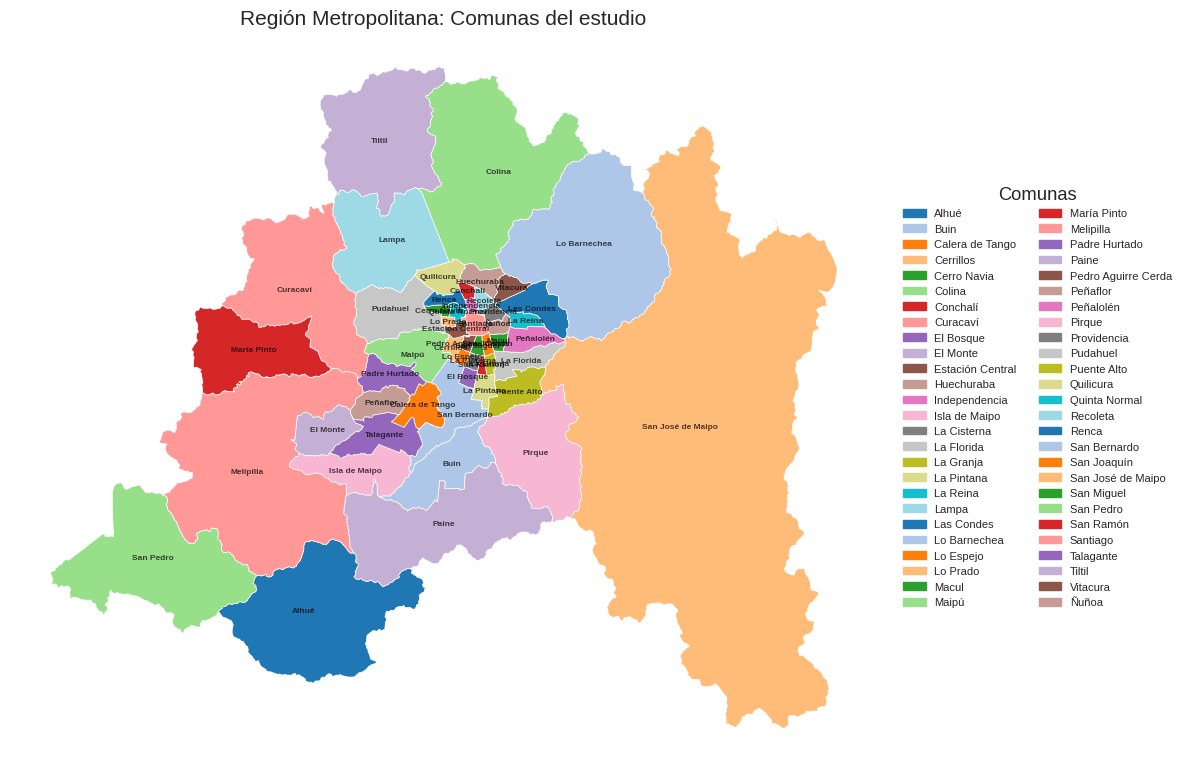

In [8]:
# ============================================================================
# CELDA 6: MAPA BASE DE COMUNAS (CORREGIDO)
# ============================================================================
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib as mpl

# 1. Configuración de colores (Fix Matplotlib Deprecation)
comunas_nombres = sorted(gdf_final["comuna"].unique())
n_comunas = len(comunas_nombres)
cmap = mpl.colormaps["tab20"] # Forma moderna de llamar al colormap

fig, ax = plt.subplots(figsize=(12, 10))

# 2. Pintar cada comuna
for i, nombre in enumerate(comunas_nombres):
    # Obtener color del mapa (cycling si son más de 20)
    color = cmap(i % 20)
    
    gdf_final[gdf_final["comuna"] == nombre].plot(
        ax=ax,
        color=color,
        edgecolor="white",
        linewidth=0.5
    )

# 3. Etiquetas
for idx, row in gdf_final.iterrows():
    # Usamos representative_point() que asegura que la etiqueta quede DENTRO del polígono
    centroid = row.geometry.representative_point()
    ax.text(
        centroid.x, centroid.y,
        row["comuna"],
        fontsize=6,
        ha="center", va="center",
        color="black", fontweight="bold", alpha=0.7
    )

ax.set_title("Región Metropolitana: Comunas del estudio", fontsize=15)
ax.set_axis_off()

# 4. Leyenda externa
handles = []
for i, nombre in enumerate(comunas_nombres):
    color = cmap(i % 20)
    patch = mpatches.Patch(color=color, label=nombre)
    handles.append(patch)

ax.legend(
    handles=handles,
    title="Comunas",
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    fontsize=8,
    frameon=False,
    ncol=2 # Dos columnas para que no sea tan larga
)

plt.tight_layout()
save_figure(fig, "mapa_rm_base_referencia", subdir="area_estudio")
plt.show()

✅ Cargado Capa 'establecimientos_salud': 1027 registros | CRS: EPSG:32719
🖼️  Imagen guardada: mapa_dist_salud.png


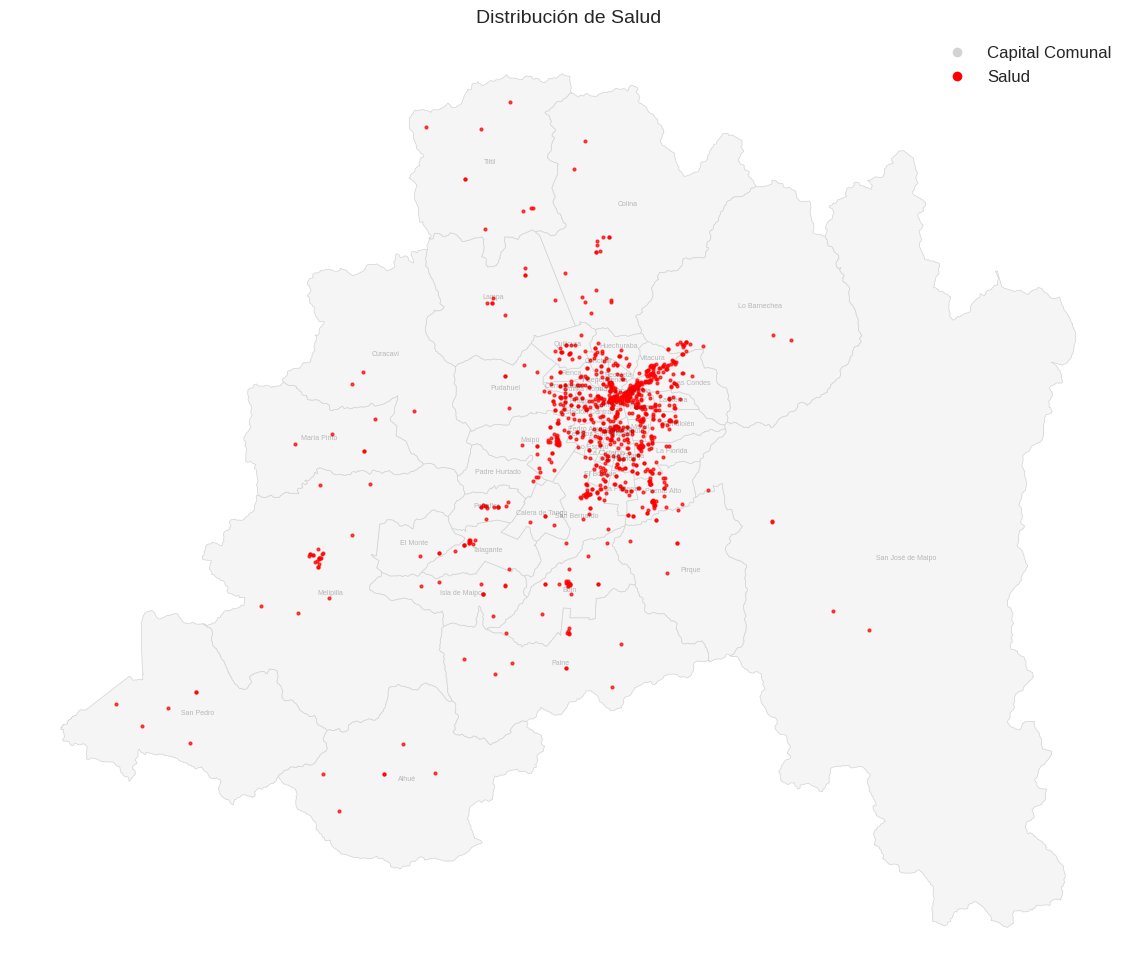

✅ Cargado Capa 'establecimientos_educacion': 2918 registros | CRS: EPSG:32719
🖼️  Imagen guardada: mapa_dist_educacion.png


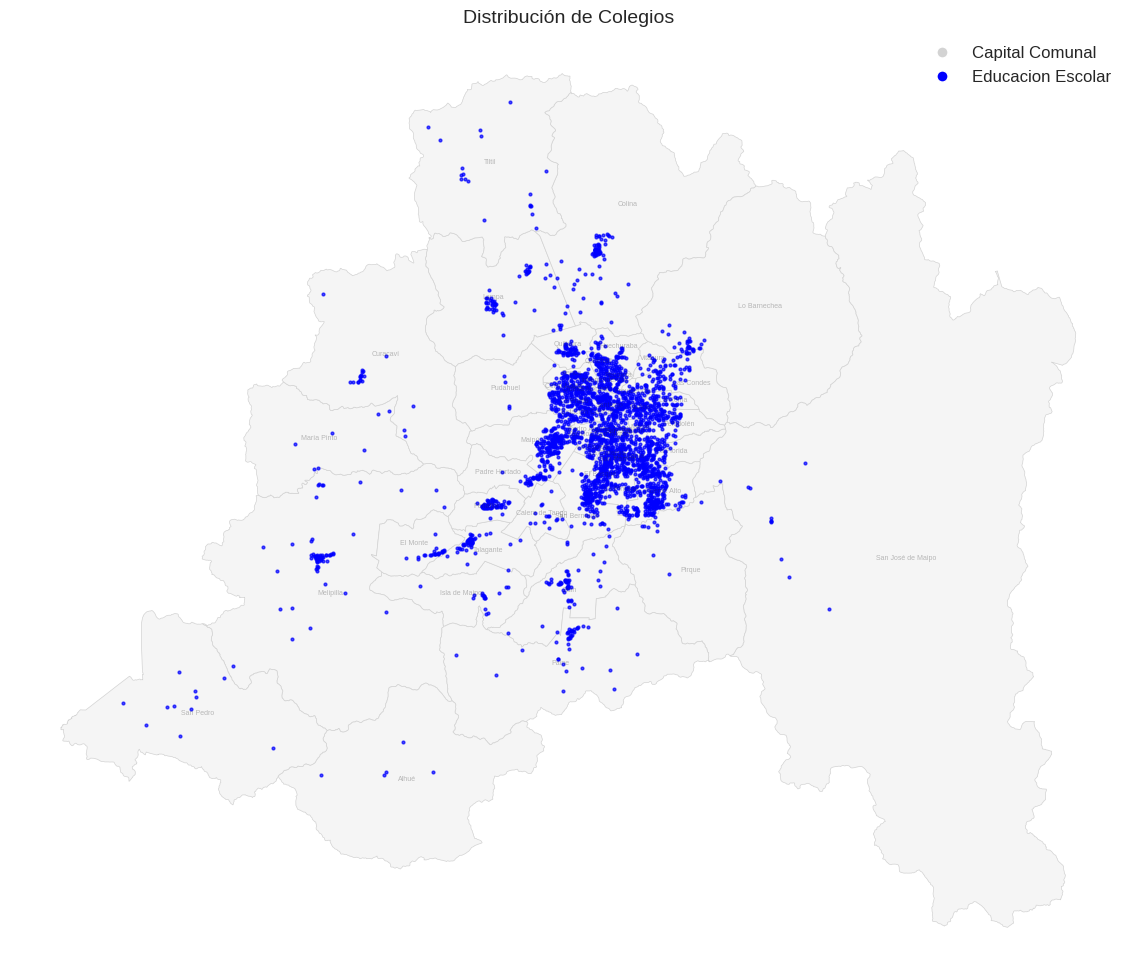

✅ Cargado Capa 'osm_supermercados': 546 registros | CRS: EPSG:32719
🖼️  Imagen guardada: mapa_dist_supermercados.png


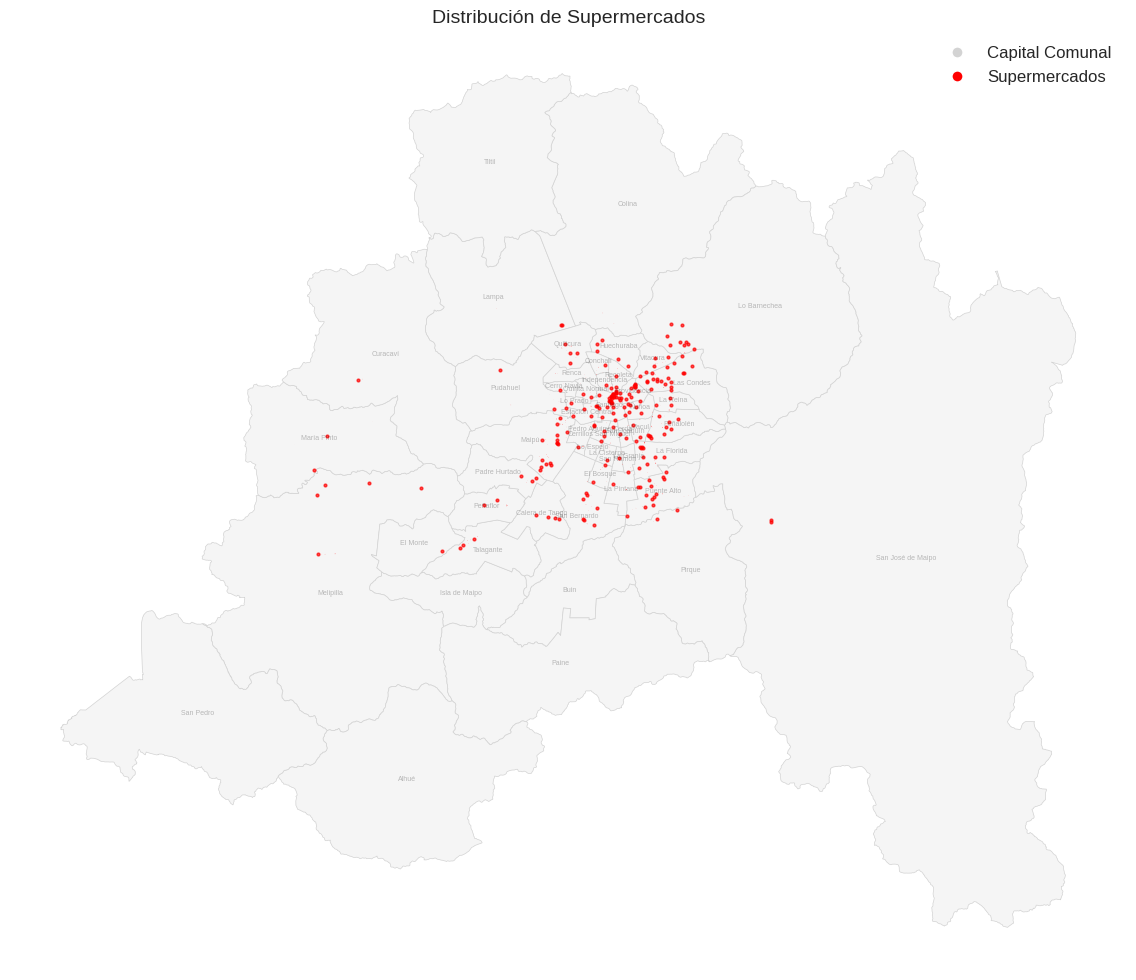

✅ Cargado Capa 'areas_verdes': 7508 registros | CRS: EPSG:32719
🖼️  Imagen guardada: mapa_dist_areas_verdes.png


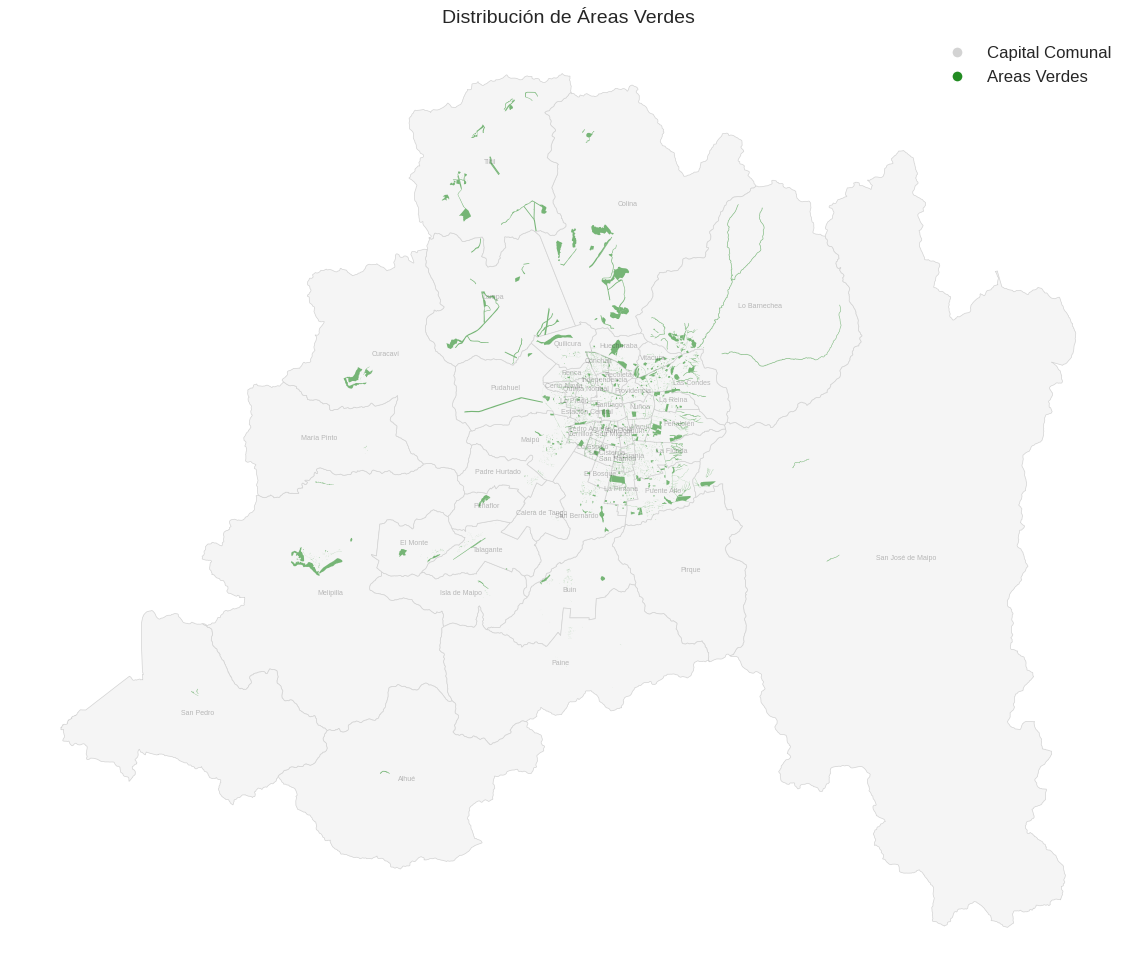

In [9]:
# ============================================================================
# CELDA 7: MAPAS DE DISTRIBUCIÓN DE SERVICIOS
# ============================================================================
from matplotlib.lines import Line2D

def plot_servicio_coloreado(alias_servicio, titulo_mapa, nombre_archivo):
    """
    Dibuja las comunas de fondo y superpone la capa del servicio solicitado.
    Usa el diccionario SERVICE_LAYERS_MAP para encontrar el archivo.
    """
    # Recuperar nombre real de la capa
    layer_gpkg = SERVICE_LAYERS_MAP.get(alias_servicio)
    if not layer_gpkg:
        print(f"⚠️ Servicio '{alias_servicio}' no encontrado en el mapa.")
        return

    # Cargar capa
    gdf_serv = load_geodata(RUTA_GPKG, layer=layer_gpkg)
    if gdf_serv is None: return
    
    # Proyectar
    if gdf_serv.crs != gdf_final.crs:
        gdf_serv = gdf_serv.to_crs(gdf_final.crs)

    # Configuración de estilo según tipo de servicio
    color_puntos = "red"
    marker_style = "o"
    if alias_servicio == "areas_verdes":
        color_puntos = "forestgreen"
    elif alias_servicio == "educacion_escolar":
        color_puntos = "blue"

    # --- PLOT ---
    fig, ax = plt.subplots(figsize=(12, 10))

    # 1. Fondo Comunas (Reutilizamos la lógica de colores suaves)
    gdf_final.plot(ax=ax, color='whitesmoke', edgecolor='lightgray', linewidth=0.5)
    
    # 2. Capa de Servicios
    # Si son polígonos (areas verdes), plot normal. Si son puntos, markersize.
    if alias_servicio == "areas_verdes":
        gdf_serv.plot(ax=ax, color=color_puntos, alpha=0.6)
    else:
        gdf_serv.plot(ax=ax, color=color_puntos, markersize=4, alpha=0.7)

    # 3. Etiquetas de comunas (opcional, para referencia)
    for idx, row in gdf_final.iterrows():
        c = row.geometry.centroid
        ax.text(c.x, c.y, row["comuna"], fontsize=5, alpha=0.3, ha='center')

    ax.set_title(titulo_mapa, fontsize=14)
    ax.set_axis_off()

    # 4. Leyenda Personalizada
    leyenda_elementos = [
        Line2D([0], [0], marker='o', color='w', label='Capital Comunal', 
               markerfacecolor='lightgray', markersize=8),
        Line2D([0], [0], marker='o', color='w', label=alias_servicio.replace("_", " ").title(), 
               markerfacecolor=color_puntos, markersize=8)
    ]
    
    ax.legend(handles=leyenda_elementos, loc="upper right")

    plt.tight_layout()
    save_figure(fig, nombre_archivo, subdir="distribucion_servicios")
    plt.show()

# --- EJECUCIÓN DE MAPAS ---
plot_servicio_coloreado("salud", "Distribución de Salud", "mapa_dist_salud")
plot_servicio_coloreado("educacion_escolar", "Distribución de Colegios", "mapa_dist_educacion")
plot_servicio_coloreado("supermercados", "Distribución de Supermercados", "mapa_dist_supermercados")
plot_servicio_coloreado("areas_verdes", "Distribución de Áreas Verdes", "mapa_dist_areas_verdes")

🖼️  Imagen guardada: barras_comparativas_servicios.png


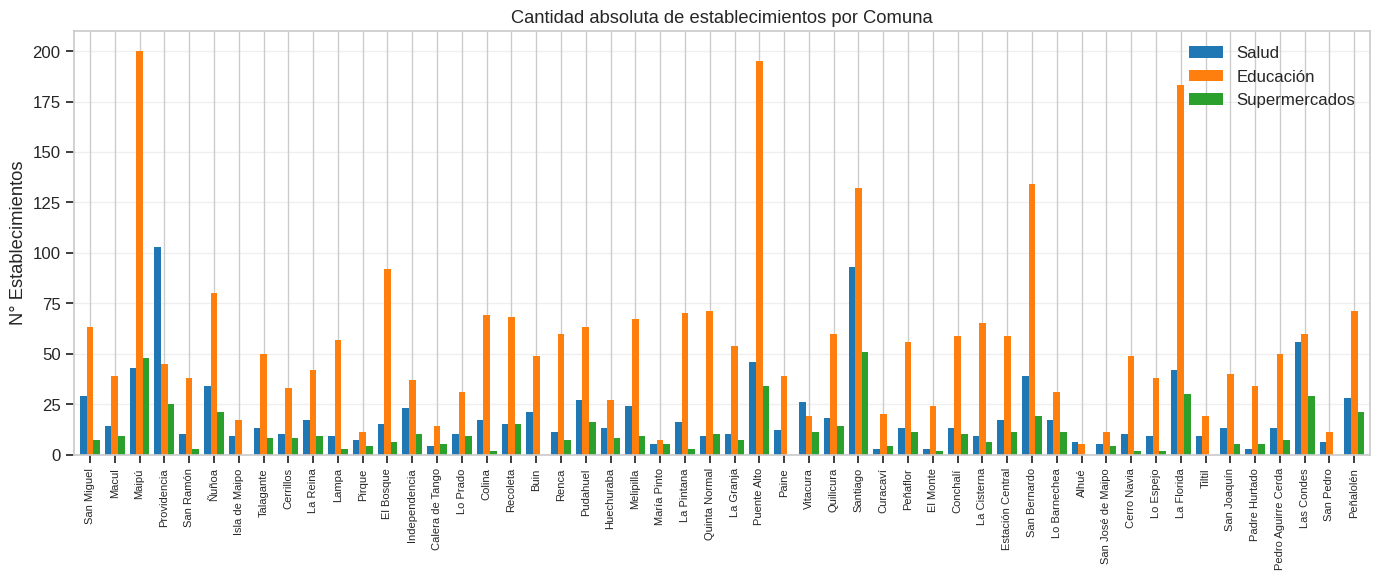

🖼️  Imagen guardada: boxplot_educacion.png


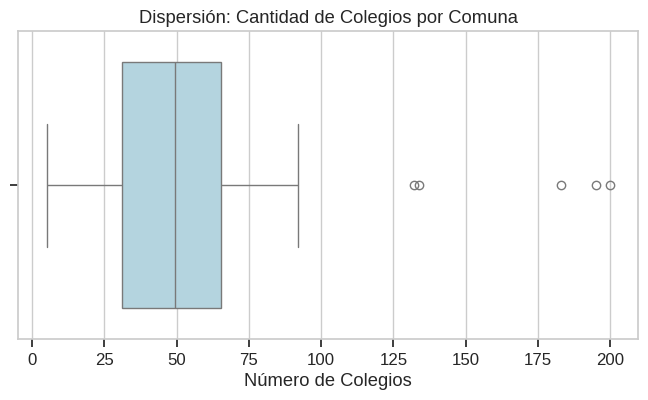

In [10]:
# ============================================================================
# CELDA 8: ESTADÍSTICAS DESCRIPTIVAS Y GRÁFICOS
# ============================================================================
import seaborn as sns

# 1. Comparación de Barras (Salud vs Educación vs Supermercados)
# Usamos los nombres REALES de las capas para las columnas de conteo
cols_interes = [
    "conteo_establecimientos_salud", 
    "conteo_establecimientos_educacion", 
    "conteo_osm_supermercados"
]

# Verificar que existan
cols_existentes = [c for c in cols_interes if c in gdf_final.columns]

if cols_existentes:
    # Preparamos datos para plotear (Indexamos por nombre de comuna)
    df_plot = gdf_final.set_index("comuna")[cols_existentes]
    
    # Renombramos columnas para que el gráfico se vea bonito
    df_plot.columns = ["Salud", "Educación", "Supermercados"]
    
    fig, ax = plt.subplots(figsize=(14, 6))
    df_plot.plot(kind="bar", ax=ax, width=0.8)
    
    ax.set_title("Cantidad absoluta de establecimientos por Comuna")
    ax.set_ylabel("N° Establecimientos")
    ax.set_xlabel("")
    plt.xticks(rotation=90, fontsize=8)
    plt.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    save_figure(fig, "barras_comparativas_servicios")
    plt.show()

# 2. Boxplot de Educación (Dispersión)
if "conteo_establecimientos_educacion" in gdf_final.columns:
    fig, ax = plt.subplots(figsize=(8, 4))
    sns.boxplot(x=gdf_final["conteo_establecimientos_educacion"], color="lightblue", ax=ax)
    ax.set_title("Dispersión: Cantidad de Colegios por Comuna")
    ax.set_xlabel("Número de Colegios")
    save_figure(fig, "boxplot_educacion")
    plt.show()

🖼️  Imagen guardada: choro_tasa_salud_10k.png


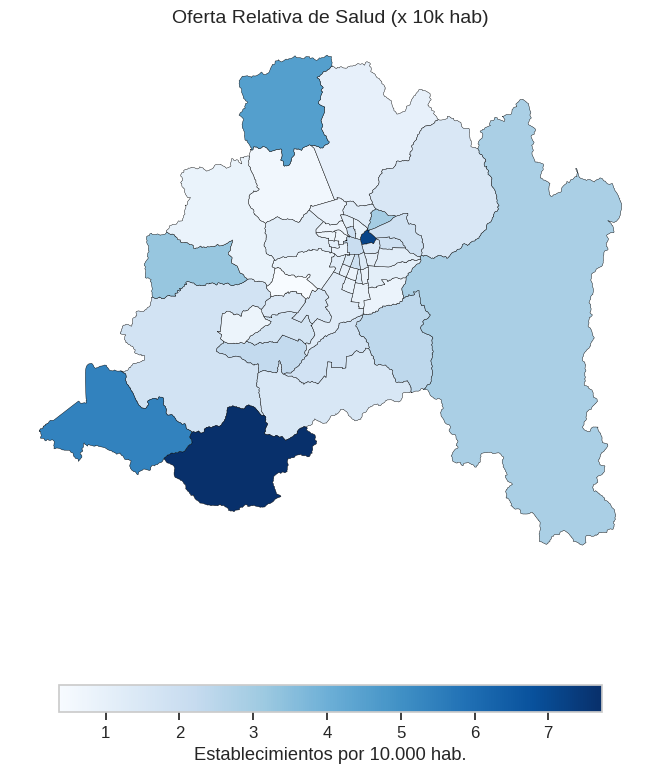

🖼️  Imagen guardada: choro_tasa_areas_verdes_10k.png


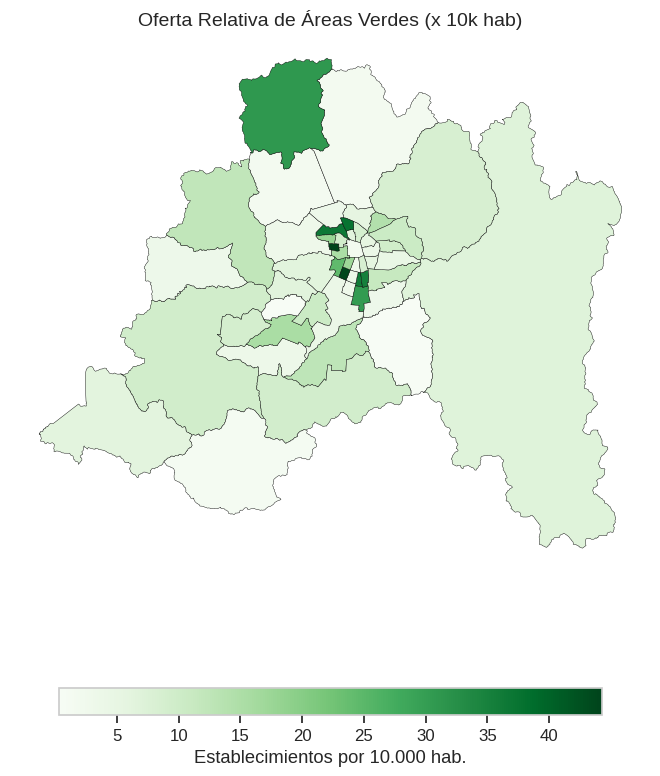

🖼️  Imagen guardada: choro_tasa_supermercados_10k.png


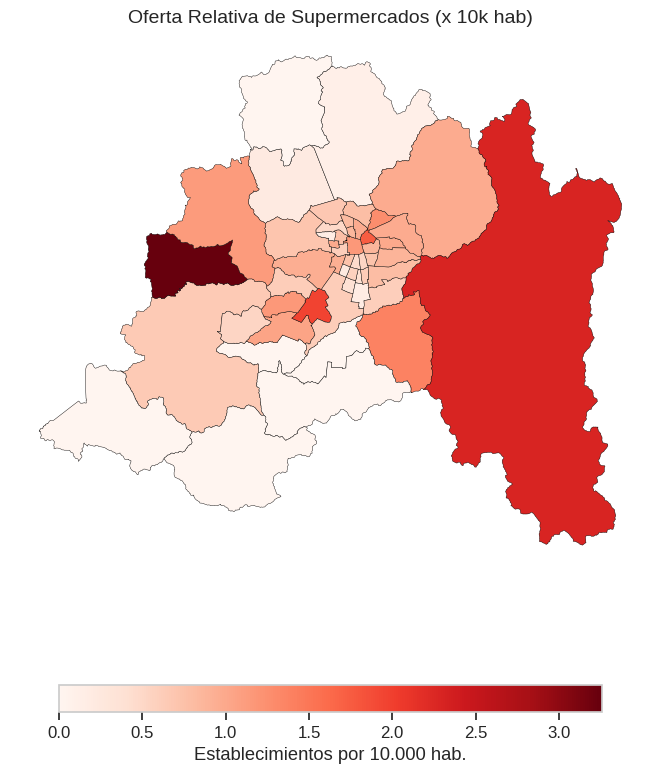


💾 Archivo guardado exitosamente: /home/jovyan/data/processed/indicadores_servicios_comunales.csv


In [11]:
# ============================================================================
# CELDA 9: MAPAS DE CALOR (TASAS X 10k HAB) Y EXPORTACIÓN
# ============================================================================

def plot_choropleth(columna_tasa, titulo, cmap="YlOrRd"):
    if columna_tasa not in gdf_final.columns:
        print(f"Columna {columna_tasa} no encontrada.")
        return
        
    fig, ax = plt.subplots(figsize=(10, 10))
    
    gdf_final.plot(
        column=columna_tasa,
        cmap=cmap,
        legend=True,
        legend_kwds={'label': "Establecimientos por 10.000 hab.", 'orientation': "horizontal", 'shrink': 0.7},
        ax=ax,
        edgecolor="black",
        linewidth=0.3
    )
    
    ax.set_title(titulo, fontsize=14)
    ax.set_axis_off()
    
    save_figure(fig, f"choro_{columna_tasa}")
    plt.show()

# Generamos mapas para indicadores clave usando los ALIAS
plot_choropleth("tasa_salud_10k", "Oferta Relativa de Salud (x 10k hab)", "Blues")
plot_choropleth("tasa_areas_verdes_10k", "Oferta Relativa de Áreas Verdes (x 10k hab)", "Greens")
plot_choropleth("tasa_supermercados_10k", "Oferta Relativa de Supermercados (x 10k hab)", "Reds")

# --- EXPORTACIÓN FINAL ---
# Guardamos solo el CSV de indicadores (sin geometría) para el siguiente notebook
output_path = PROCESSED_DATA / "indicadores_servicios_comunales.csv"
df_indicadores.to_csv(output_path, index=False)
print(f"\n💾 Archivo guardado exitosamente: {output_path}")

🖼️  Imagen guardada: heatmap_vertical_poblacion.png


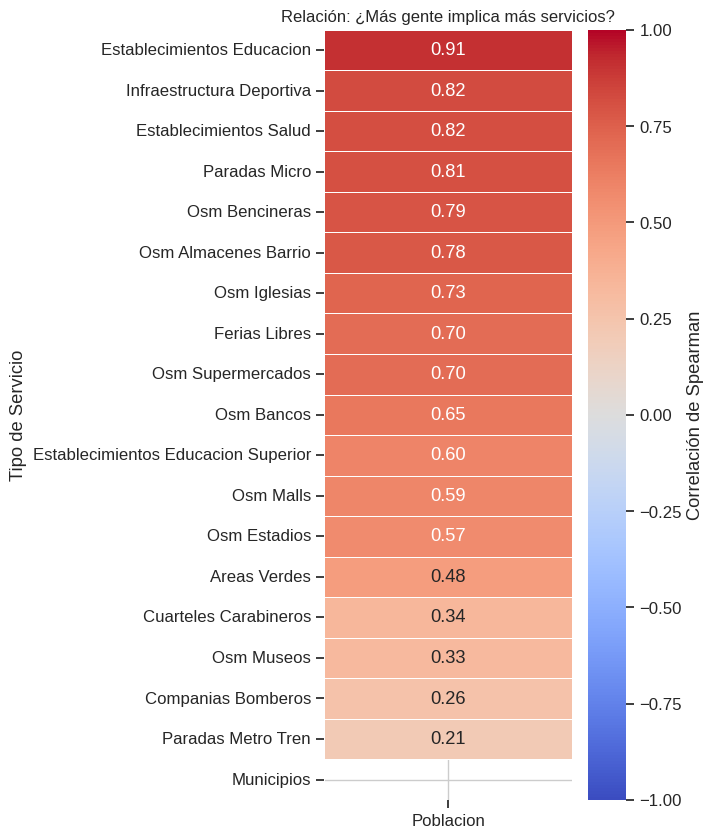

In [12]:
# ============================================================================
# CELDA 10: CORRELACIÓN ENFOCADA (POBLACIÓN VS SERVICIOS)
# ============================================================================

# 1. Preparamos los datos
cols_conteo = [c for c in gdf_final.columns if c.startswith("conteo_")]
df_corr = gdf_final[["poblacion"] + cols_conteo].copy()

# Limpiamos nombres (quitamos 'conteo_' y ponemos mayúsculas)
df_corr.columns = [c.replace("conteo_", "").replace("_", " ").title() for c in df_corr.columns]

# 2. Calculamos la matriz completa pero nos quedamos solo con la columna 'Poblacion'
corr_matrix = df_corr.corr(method='spearman')
corr_poblacion = corr_matrix[["Poblacion"]].drop("Poblacion") # Sacamos la fila de sí misma

# 3. Ordenamos de mayor correlación a menor para facilitar la lectura
corr_poblacion = corr_poblacion.sort_values(by="Poblacion", ascending=False)

# 4. Graficamos una "Barra de Calor"
plt.figure(figsize=(4, 10))  # Figura alta y angosta

sns.heatmap(
    corr_poblacion, 
    annot=True, 
    fmt=".2f", 
    cmap="coolwarm", 
    vmin=-1, vmax=1,
    cbar_kws={"label": "Correlación de Spearman"},
    linewidths=0.5
)

plt.title("Relación: ¿Más gente implica más servicios?", fontsize=12)
plt.ylabel("Tipo de Servicio")
plt.tight_layout()
save_figure(plt.gcf(), "heatmap_vertical_poblacion")
plt.show()

🖼️  Imagen guardada: heatmap_tasas_vs_poblacion.png


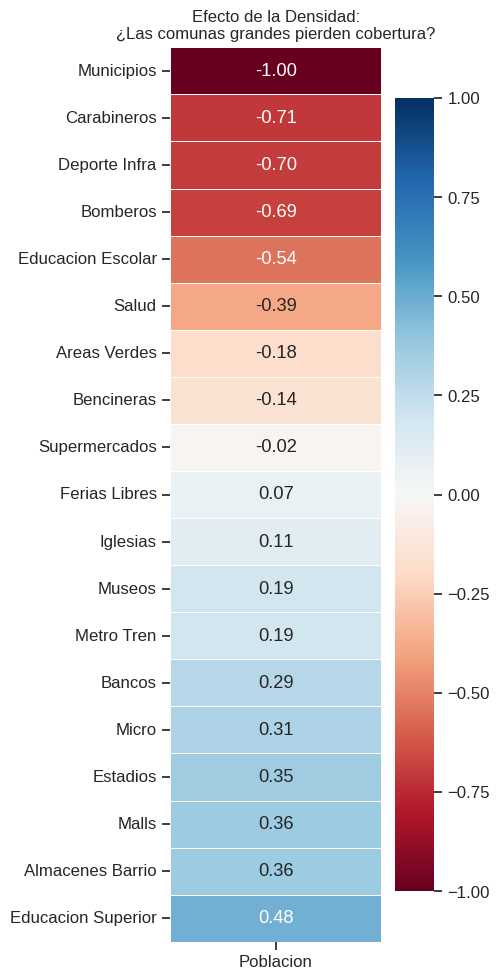

In [13]:
# ============================================================================
# CELDA 11: CORRELACIÓN DE TASAS (CALIDAD DE COBERTURA)
# ============================================================================

# 1. Usamos las columnas de TASA en vez de CONTEO
cols_tasa = [c for c in gdf_final.columns if c.startswith("tasa_")]
df_calidad = gdf_final[["poblacion"] + cols_tasa].copy()

# Nombres más cortos para el gráfico
nombres_limpios = [c.replace("tasa_", "").replace("_10k", "").replace("_", " ").title() for c in cols_tasa]
df_calidad.columns = ["Poblacion"] + nombres_limpios

# 2. Correlación
corr_calidad = df_calidad.corr(method='spearman')[["Poblacion"]].drop("Poblacion")
corr_calidad = corr_calidad.sort_values(by="Poblacion", ascending=True) # Ordenamos del más negativo al positivo

# 3. Gráfico
plt.figure(figsize=(5, 10))

sns.heatmap(
    corr_calidad, 
    annot=True, 
    fmt=".2f", 
    cmap="RdBu",  # Red-Blue (Rojo=Bajo, Azul=Alto) o al revés según prefieras
    vmin=-1, vmax=1,
    linewidths=0.5
)

plt.title("Efecto de la Densidad:\n¿Las comunas grandes pierden cobertura?", fontsize=12)
plt.tight_layout()
save_figure(plt.gcf(), "heatmap_tasas_vs_poblacion")
plt.show()

In [14]:
# ============================================================================
# CELDA 12: IDENTIFICACIÓN DE ZONAS CON MENOR OFERTA (RANKING)
# ============================================================================

# Definimos qué servicios son críticos para el análisis
servicios_criticos = ["salud", "educacion_escolar", "supermercados", "areas_verdes"]

print("📊 RANKING DE COMUNAS CON MENOR OFERTA (Tasa x 10.000 hab):\n")

for servicio in servicios_criticos:
    # Construimos el nombre de la columna tasa
    col_tasa = f"tasa_{servicio}_10k"
    
    if col_tasa in gdf_final.columns:
        # Ordenamos de menor a mayor y tomamos las 5 peores
        top_desiertos = gdf_final[["comuna", col_tasa]].sort_values(col_tasa).head(5)
        
        print(f"🔻 Peores 5 comunas en {servicio.upper()}:")
        for idx, row in top_desiertos.iterrows():
            print(f"   {row['comuna']:<20} : {row[col_tasa]:.2f} estab/10k hab")
        print("-" * 40)
    else:
        print(f"⚠️ Columna {col_tasa} no encontrada.")

# Opcional: Guardar este resumen en un CSV pequeño para el informe
resumen_path = REPORTS_DIR / "ranking_desiertos_servicios.csv"
gdf_final[["comuna"] + [f"tasa_{s}_10k" for s in servicios_criticos]].to_csv(resumen_path, index=False)
print(f"\n💾 Tabla de rankings guardada en: {resumen_path}")

📊 RANKING DE COMUNAS CON MENOR OFERTA (Tasa x 10.000 hab):

🔻 Peores 5 comunas en SALUD:
   Padre Hurtado        : 0.37 estab/10k hab
   Lampa                : 0.62 estab/10k hab
   Quinta Normal        : 0.70 estab/10k hab
   Renca                : 0.77 estab/10k hab
   Cerro Navia          : 0.79 estab/10k hab
----------------------------------------
🔻 Peores 5 comunas en EDUCACION_ESCOLAR:
   Las Condes           : 2.03 estab/10k hab
   Vitacura             : 2.20 estab/10k hab
   Huechuraba           : 2.65 estab/10k hab
   Lo Barnechea         : 2.75 estab/10k hab
   Pudahuel             : 2.77 estab/10k hab
----------------------------------------
🔻 Peores 5 comunas en SUPERMERCADOS:
   San Pedro            : 0.00 estab/10k hab
   Paine                : 0.00 estab/10k hab
   Buin                 : 0.00 estab/10k hab
   Isla de Maipo        : 0.00 estab/10k hab
   Tiltil               : 0.00 estab/10k hab
----------------------------------------
🔻 Peores 5 comunas en AREAS_VERDES:

In [15]:
# ============================================================================
# CELDA 13: IDENTIFICACIÓN DE "OASIS" DE SERVICIOS (TOP 5 MEJORES)
# ============================================================================

print("🏆 RANKING DE COMUNAS CON MAYOR OFERTA (Tasa x 10.000 hab):\n")

# Reutilizamos la lista de servicios críticos de la celda anterior
if 'servicios_criticos' not in locals():
    servicios_criticos = ["salud", "educacion_escolar", "supermercados", "areas_verdes"]

for servicio in servicios_criticos:
    # Construimos el nombre de la columna
    col_tasa = f"tasa_{servicio}_10k"
    
    if col_tasa in gdf_final.columns:
        # AQUÍ ESTÁ EL CAMBIO: Ordenamos de MAYOR a MENOR (ascending=False)
        top_oasis = gdf_final[["comuna", col_tasa]].sort_values(col_tasa, ascending=False).head(5)
        
        print(f"🌟 Mejores 5 comunas en {servicio.upper()}:")
        for idx, row in top_oasis.iterrows():
            print(f"   {row['comuna']:<20} : {row[col_tasa]:.2f} estab/10k hab")
        print("-" * 40)
    else:
        print(f"⚠️ Columna {col_tasa} no encontrada.")

print("\n💡 NOTA DE ANÁLISIS:")
print("Si aparecen comunas rurales pequeñas (ej. Alhué, San Pedro) en el top,")
print("es porque tienen muy poca población, lo que infla artificialmente su tasa.")
print("Fíjate si aparecen comunas centrales (Santiago, Providencia), esos son los verdaderos hubs.")

🏆 RANKING DE COMUNAS CON MAYOR OFERTA (Tasa x 10.000 hab):

🌟 Mejores 5 comunas en SALUD:
   Alhué                : 7.72 estab/10k hab
   Providencia          : 7.15 estab/10k hab
   San Pedro            : 5.40 estab/10k hab
   Tiltil               : 4.56 estab/10k hab
   María Pinto          : 3.26 estab/10k hab
----------------------------------------
🌟 Mejores 5 comunas en EDUCACION_ESCOLAR:
   San Pedro            : 9.90 estab/10k hab
   Tiltil               : 9.62 estab/10k hab
   Talagante            : 6.54 estab/10k hab
   Alhué                : 6.44 estab/10k hab
   El Monte             : 6.40 estab/10k hab
----------------------------------------
🌟 Mejores 5 comunas en SUPERMERCADOS:
   María Pinto          : 3.26 estab/10k hab
   San José de Maipo    : 2.29 estab/10k hab
   Calera de Tango      : 1.96 estab/10k hab
   Providencia          : 1.74 estab/10k hab
   Pirque               : 1.38 estab/10k hab
----------------------------------------
🌟 Mejores 5 comunas en AREAS_VER

In [17]:
# ============================================================================
# CELDA 14: CIERRE DEL NOTEBOOK 02 Y VERIFICACIÓN DE ARCHIVOS
# ============================================================================

print("✅ Notebook 02 Finalizado con Éxito.")
print("   Resumen de actividades:")
print("   - [x] Se generaron mapas de distribución y calor (Oferta vs Demanda).")
print("   - [x] Se calcularon matrices de correlación y rankings (Top 5 / Bottom 5).")

# Definimos los archivos que deberían existir
archivo_indicadores = PROCESSED_DATA / "indicadores_servicios_comunales.csv"
archivo_ranking     = REPORTS_DIR / "ranking_desiertos_servicios.csv"

# Verificamos
archivos_ok = True

if archivo_indicadores.exists():
    print(f"   - [x] Exportado dataset para ML: {archivo_indicadores.name}")
else:
    print(f"   - [ ] ❌ FALTA: {archivo_indicadores.name}")
    archivos_ok = False

if archivo_ranking.exists():
    print(f"   - [x] Exportado tabla para Informe: {archivo_ranking.name}")
else:
    print(f"   - [ ] ⚠️ AVISO: No se encontró el ranking (revisar Celda 11/12).")
    # No fallamos el notebook por esto, pero avisamos.

print("-" * 60)
if archivos_ok:
    print("🚀 TODO LISTO: Los datos están preparados.")
    print("   Próximo paso: Abrir '03_geostatistics.ipynb' para análisis de distancias.")
else:
    print("⚠️ REVISA LOS ERRORES ANTES DE CONTINUAR.")

✅ Notebook 02 Finalizado con Éxito.
   Resumen de actividades:
   - [x] Se generaron mapas de distribución y calor (Oferta vs Demanda).
   - [x] Se calcularon matrices de correlación y rankings (Top 5 / Bottom 5).
   - [x] Exportado dataset para ML: indicadores_servicios_comunales.csv
   - [x] Exportado tabla para Informe: ranking_desiertos_servicios.csv
------------------------------------------------------------
🚀 TODO LISTO: Los datos están preparados.
   Próximo paso: Abrir '03_geostatistics.ipynb' para análisis de distancias.
